In [1]:
# Install dependencies for Stable Diffusion and Detectron2
!pip install torch torchvision
!pip install diffusers transformers accelerate
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!pip install -U 'git+https://github.com/facebookresearch/fvcore.git'
!git clone https://github.com/facebookresearch/detectron2.git
!pip install -e detectron2

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

KeyboardInterrupt: 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

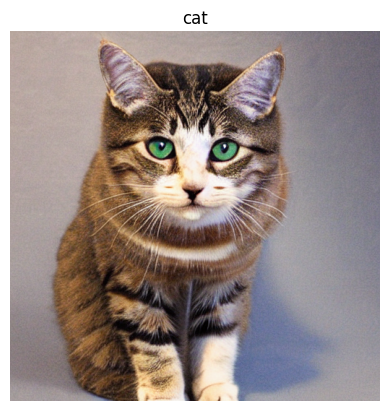

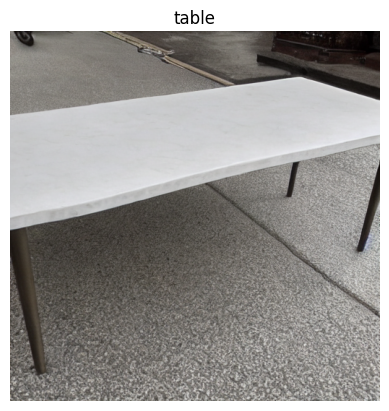

In [13]:
import torch
from diffusers import StableDiffusionPipeline
from PIL import Image
import matplotlib.pyplot as plt

# Load the Stable Diffusion model
model_id = "CompVis/stable-diffusion-v1-4"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to("cuda")

def generate_image(prompt):
    image = pipe(prompt).images[0]
    return image

# Example entities
entities = ["cat", "table"]
images = {}

for entity in entities:
    image = generate_image(entity)
    images[entity] = image
    # Optionally, save the generated image
    image.save(f"/content/drive/My Drive/Colab Notebooks/GeneratedImages/{entity}.jpg")

# Display generated images
for entity, image in images.items():
    plt.figure()
    plt.imshow(image)
    plt.title(entity)
    plt.axis('off')
    plt.show()


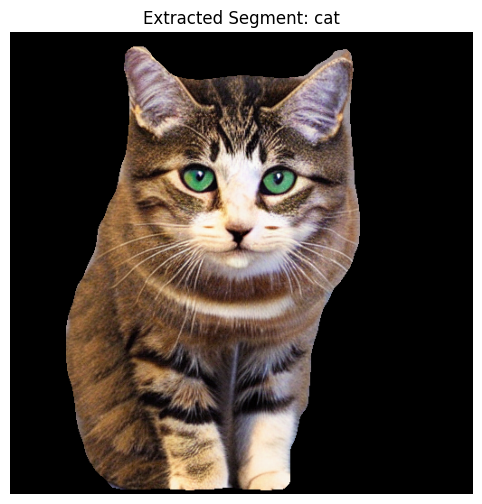

Using Original Image


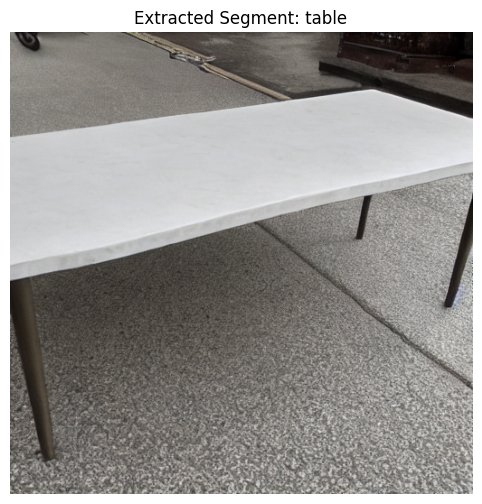

In [18]:
import cv2
import torch
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog
from detectron2.utils.visualizer import Visualizer
import matplotlib.pyplot as plt
import numpy as np

# Setup configuration
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_50_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_50_3x.yaml")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.MODEL.PANOPTIC_FPN.COMBINE.INSTANCES_CONFIDENCE_THRESH = 0.5

# Create predictor
predictor = DefaultPredictor(cfg)

def segment_entity(image, target_class_name):
    # Convert PIL image to OpenCV format
    image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

    # Perform panoptic segmentation
    outputs = predictor(image)
    panoptic_seg, segments_info = outputs["panoptic_seg"]

    # Visualize results
    v = Visualizer(image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]))
    out = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
    output_image = out.get_image()[:, :, ::-1]

    # Extract and visualize the specific segment by its class name
    metadata = MetadataCatalog.get(cfg.DATASETS.TRAIN[0])
    if target_class_name in metadata.thing_classes:
        category_id = metadata.thing_classes.index(target_class_name)  # Get the category ID for the target class

        # Create a mask for the target segment
        mask = torch.zeros_like(panoptic_seg, dtype=torch.uint8)
        segment_found = False
        for segment in segments_info:
            if segment["category_id"] == category_id:
                mask[panoptic_seg == segment["id"]] = 255
                segment_found = True

        # If the segment is found, extract it using the mask
        if segment_found:
            extracted_segment = cv2.bitwise_and(image, image, mask=mask.cpu().numpy())
            # Convert extracted segment to RGB format
            extracted_image = cv2.cvtColor(extracted_segment, cv2.COLOR_BGR2RGB)
        else:
            # If the segment is not found, use the original image
            print("Using Original Image")
            extracted_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    else:
        print("Using Original Image")
        # If the target class is not in the metadata, use the original image
        extracted_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    extracted_pil_image = Image.fromarray(extracted_image)
    extracted_pil_image.save(f"/content/drive/My Drive/Colab Notebooks/ExtractedSegments/extracted_{entity}.jpg")

    # Display the extracted segment
    plt.figure(figsize=(12, 6))
    plt.imshow(extracted_image)
    plt.axis('off')
    plt.title(f'Extracted Segment: {target_class_name}')
    plt.show()


# Example: Segment each generated image
for entity, image in images.items():
    segment_entity(image, entity)
